In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import (
    BertTokenizerFast,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

# Load datasets
app_data = pd.read_csv('/content/AppleStore.csv')
description_data = pd.read_csv('/content/appleStore_description.csv')

# Merge datasets on the appropriate index or key if necessary
app_data['app_desc'] = description_data['app_desc']
app_data = app_data.iloc[:, 1:]  # Adjust if the first column should be excluded

def generate_app_description(row):
    """
    Create a descriptive text for each app based on its attributes.
    """
    return (
        f'The app "{row["track_name"]}" is a {row["prime_genre"]} app available for {row["currency"]} currency '
        f'at a price of {row["price"]:.2f}. It has a size of approximately {row["size_bytes"] / (1024**2):.1f} MB '
        f'and supports {row["sup_devices.num"]} devices. The app description mentions: "{row["app_desc"]}" '
        f'It is rated suitable for users aged {row["cont_rating"]} and is available in {row["lang.num"]} languages. '
        f'It has been rated by {row["rating_count_tot"]} users and supports iPad-specific features with '
        f'{row["ipadSc_urls.num"]} dedicated screens.'
    )

# Generate descriptive text for each app
app_data["description"] = app_data.apply(generate_app_description, axis=1)

# Prepare data for the model
model_data = app_data[["description", "user_rating"]].copy()
model_data['user_rating_binary'] = model_data['user_rating'].apply(lambda x: 1 if x >= 4 else 0)

# Define features and labels
X = model_data['description']
y = model_data['user_rating_binary'].astype(int)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

# Load BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Tokenize the datasets
train_encodings = tokenizer(
    list(X_train),
    truncation=True,
    padding=True,
    max_length=512
)
val_encodings = tokenizer(
    list(X_val),
    truncation=True,
    padding=True,
    max_length=512
)

class AppDataset(torch.utils.data.Dataset):
    """
    Custom dataset class for handling tokenized data.
    """
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

# Create dataset objects
train_dataset = AppDataset(train_encodings, y_train)
val_dataset = AppDataset(val_encodings, y_val)

# Load pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,
    problem_type="single_label_classification"
)

def compute_metrics(pred):
    """
    Compute evaluation metrics: accuracy and F1-score.
    """
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='binary')
    return {
        'accuracy': accuracy,
        'f1': f1,
    }

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',              # Output directory
    num_train_epochs=2,                  # Number of training epochs
    per_device_train_batch_size=16,      # Training batch size per device
    per_device_eval_batch_size=16,       # Evaluation batch size per device
    evaluation_strategy='epoch',         # Evaluation strategy
    save_strategy='epoch',               # Save strategy
    logging_dir='./logs',                # Directory for logs
    logging_steps=10,                    # Log every 10 steps
    report_to=[],                        # Disable reporting to external systems
    load_best_model_at_end=True,         # Load the best model at the end of training
    metric_for_best_model='accuracy',    # Metric to determine the best model
    greater_is_better=True,              # Whether a higher metric score is better
    seed=42,                             # Random seed for reproducibility
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# Evaluate the model on the validation set
evaluation_results = trainer.evaluate()
print(f"Validation Accuracy: {evaluation_results['eval_accuracy']:.4f}")
print(f"Validation F1-Score: {evaluation_results['eval_f1']:.4f}")


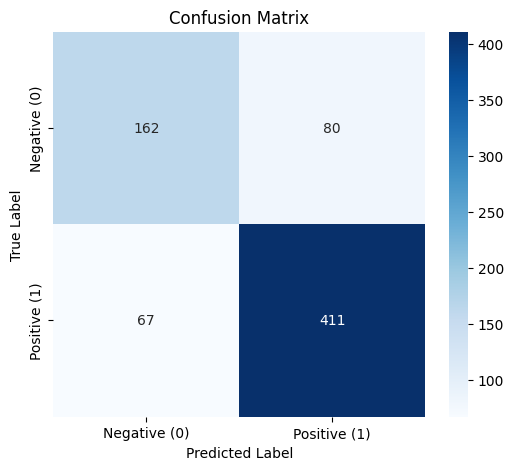

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


predictions = trainer.predict(test_dataset)

y_true = predictions.label_ids
y_pred = predictions.predictions.argmax(axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative (0)', 'Positive (1)'], yticklabels=['Negative (0)', 'Positive (1)'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
